# pytorchでRNNを使う


In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

## RNNレイヤ

基本的な使い方は他のレイヤーと同じ

- [torch.nn — PyTorch 1.11.0 documentation](https://pytorch.org/docs/stable/nn.html#recurrent-layers)
- [RNN — PyTorch 1.11.0 documentation](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

<br>

よく使われる活性化関数は `nonlinearity=` で指定できる。デフォルトでは`tanh`が指定されている

In [23]:
input_size, output_size = 2, 1
rnn = nn.RNN(input_size, output_size)

`(sequence_length, batch_size, n_features)` のデータを入力

In [26]:
sequence_length, batch_size, n_features = 3, 4, 2
x = torch.randn(sequence_length, batch_size, n_features)
x

tensor([[[ 0.4242,  0.7954],
         [-0.2305, -1.0807],
         [-0.4961,  0.0976],
         [-0.6769,  0.3924]],

        [[ 1.1872,  1.5283],
         [ 0.7403, -0.2901],
         [ 0.1185, -0.3936],
         [-0.0047,  0.8134]],

        [[ 0.6893,  0.7586],
         [ 1.2823, -1.3598],
         [-1.1564, -0.1191],
         [-0.2191,  0.5941]]])

In [27]:
rnn(x)

(tensor([[[-0.8243],
          [-0.5177],
          [-0.6200],
          [-0.6201]],
 
         [[-0.6810],
          [-0.5294],
          [-0.2651],
          [-0.4430]],
 
         [[-0.5643],
          [-0.4932],
          [-0.2216],
          [-0.4774]]], grad_fn=<StackBackward0>),
 tensor([[[-0.5643],
          [-0.4932],
          [-0.2216],
          [-0.4774]]], grad_fn=<StackBackward0>))

出力結果が2つの要素を持ったタプルで返される

1つ目の要素は、全ての出力($y_1, y_2, y_3, ... , y_n $)、がbatch_size分  
2つ目の要素は、sequenceの最後の出力$y_n$ がbatch_size分

### 扱う形状の変更

`(sequence_length, batch_size, n_features)` はなんか分かり辛い。  
`(batch_size, sequence_length, n_features)` の方がいい

-> `batch_first=True`とする

In [30]:
rnn = nn.RNN(input_size, output_size, batch_first=True)
x = torch.randn(batch_size, sequence_length, n_features)
print('形状', x.size())
rnn(x)

形状 torch.Size([4, 3, 2])


(tensor([[[-0.7578],
          [-0.3089],
          [-0.7879]],
 
         [[-0.8825],
          [ 0.2997],
          [-0.7781]],
 
         [[ 0.1638],
          [ 0.6423],
          [-0.7034]],
 
         [[-0.1079],
          [ 0.3640],
          [ 0.0189]]], grad_fn=<TransposeBackward1>),
 tensor([[[-0.7879],
          [-0.7781],
          [-0.7034],
          [ 0.0189]]], grad_fn=<StackBackward0>))

わかりやすーい(感想)

## ネットワーク構築

In [110]:
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.RNN(1, 20, batch_first=True)
        self.l2 = nn.Linear(20, 1)

    def forward(self, z0):
        z1 = self.l1(z0)[1]
        z2 = self.l2(z1)
        return z2

最後の出力だけ使いたいので

> `self.l1(z0)[1]`  

としている

## 学習データ

ぺたぺた

In [111]:
batch_size = 256

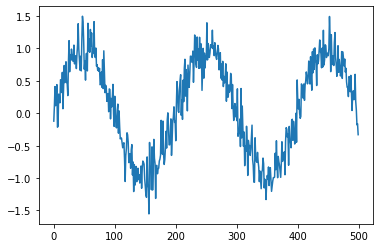

In [115]:
import my_datasets # 自作モジュール
import matplotlib.pyplot as plt

sin_y = my_datasets.SinNoise(10000)
X, y = sin_y.split(50)
X = torch.FloatTensor(X).reshape(-1, 50, 1)
y = torch.FloatTensor(y).reshape(-1, 1)
datasets = torch.utils.data.TensorDataset(X, y)
data_loader = torch.utils.data.DataLoader(
    dataset=datasets,
    batch_size=batch_size,
    shuffle=True)

plt.plot(sin_y[:500]);

## 学習

In [135]:
def train(model, optimizer, data_loader):
    model.train()
    for (X, labels) in data_loader:
        optimizer.zero_grad()
        y = model(X)
        loss = F.mse_loss(y.reshape(-1, 1), labels)
        loss.backward()
        optimizer.step()

    return loss.item()

In [136]:
model = RNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

In [137]:
losses = []
for epoch in range(epochs):
    loss = train(model, optimizer, data_loader)
    print(f'{epoch + 1:>2} epoch loss:{loss}')
    losses.append(loss)

 1 epoch loss:0.21342849731445312
 2 epoch loss:0.05953802540898323
 3 epoch loss:0.05128423124551773
 4 epoch loss:0.052593544125556946
 5 epoch loss:0.05322190374135971
 6 epoch loss:0.05253501981496811
 7 epoch loss:0.050250742584466934
 8 epoch loss:0.05088779702782631
 9 epoch loss:0.05087688937783241
10 epoch loss:0.04721339792013168


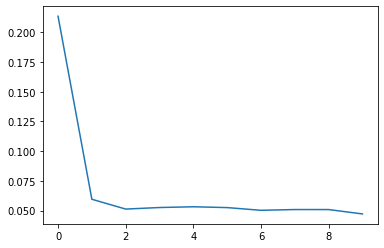

In [138]:
plt.plot(losses);

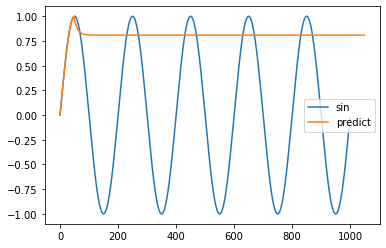

In [139]:
n = 50
n_iter = 1000
sin = my_datasets.SinNoise(n, std=0)
sin = torch.FloatTensor(sin).reshape(-1, 1)

for _ in range(n_iter):
    sin = torch.cat((sin, model(sin[-n:])))

plt.plot(my_datasets.SinNoise(n_iter, std=0), label='sin')
plt.plot(sin.detach().numpy(), label='predict')
plt.legend();

回数足りないかな?

In [141]:
epochs = 500
losses = []
for epoch in range(epochs):
    loss = train(model, optimizer, data_loader)
    # print(f'{epoch + 1:>3} epoch loss:{loss}')
    losses.append(loss)

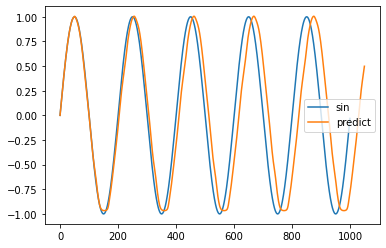

In [142]:
sin = my_datasets.SinNoise(n, std=0)
sin = torch.FloatTensor(sin).reshape(-1, 1)
for _ in range(n_iter):
    sin = torch.cat((sin, model(sin[-n:])))
plt.plot(my_datasets.SinNoise(n_iter, std=0), label='sin')
plt.plot(sin.detach().numpy(), label='predict')
plt.legend();

lossは意味わからんけど

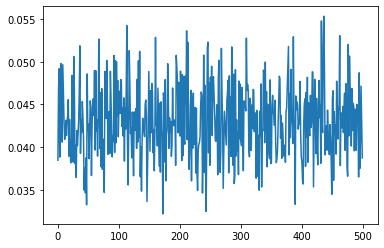

In [146]:
plt.plot(losses);